In [1]:
from utils import *
import tensorflow as tf
from network_parts import *
import os
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [2]:
shape = 100, 100
num_channels = 1
vec_size = 64

In [3]:
X, Y = [], []
class_names = []
data_path = 'data/'

for dir in os.listdir(data_path):
    if os.path.isdir(os.path.join(data_path, dir)):
        class_names.append(dir)
        files = load_dir(os.path.join(data_path, dir), shape=shape)
        X.extend(files)
        Y.extend([len(class_names)-1 for _ in range(len(files))])

X = np.array(X)
Y = np.array(Y)

X = X.reshape([-1, shape[0], shape[1], 1])

In [4]:
num_classes = len(class_names)

In [5]:
np.array(class_names).dump('class_names')

## Architecture

In [5]:
x = tf.placeholder(tf.float32, shape=[None, shape[0], shape[1], num_channels])
y = tf.placeholder(tf.int32, shape=[None])

#### V_0

In [6]:
with tf.variable_scope('encoder'):
    mean, std = encoder(x, vec_size)

In [7]:
z = mean + std * tf.random_uniform(tf.shape(mean), 0, 1, dtype=tf.float32)

In [8]:
with tf.variable_scope('classifier'):
    output = classifier(z, num_classes)

#### Output

In [9]:
one_hoted = tf.one_hot(y, num_classes)

loss_ = tf.losses.softmax_cross_entropy(one_hoted, output)

In [10]:
optim = tf.train.AdamOptimizer().minimize(loss_, var_list=list(filter(lambda x: 'classifier' in x.name, tf.global_variables())))

In [11]:
final_output = tf.nn.softmax(output)

### Training

In [13]:
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

In [14]:
save = tf.train.Saver(list(filter(lambda x: 'classifier' in x.name, tf.global_variables())))

In [15]:
tf.train.Saver(list(filter(lambda x: 'encoder' in x.name, tf.global_variables()))).restore(sess, 'new_weights/VAE_notMNIST_56',)

In [16]:
save.restore(sess, 'weights/classifier')

In [16]:
indexes = np.arange(len(X))

np.random.shuffle(indexes)

In [17]:
train, test = indexes[:int(0.8*len(X))], indexes[int(0.8*len(X)):]

In [18]:
epochs = 25
batchsize = 10

for e in range(epochs):
    print('Epoch: ', e)
    losses = []
    for i in range(0, len(train)-batchsize, batchsize):
        _, loss = sess.run([optim, loss_], feed_dict={x: X[train[i:i+batchsize]], y: Y[train[i:i+batchsize]]})
        losses.append(loss)
        if i % 1000 == 0:
            print('Loss: ', np.mean(losses))
            
    print('Epoch loss: ', np.mean(losses))
    
    test_loss = []
    for i in range(0, len(test)-batchsize, batchsize):
        loss = sess.run(loss_, feed_dict={x: X[test[i:i+batchsize]], y: Y[test[i:i+batchsize]]})
        test_loss.append(loss)
    print('Test loss: ', np.mean(test_loss))

Epoch:  0
Loss:  168.843
Loss:  39.8713
Loss:  21.9705
Loss:  15.4324
Loss:  12.1448
Loss:  10.1468
Loss:  8.8062
Loss:  7.8509
Loss:  7.11573
Loss:  6.54849
Loss:  6.08523
Loss:  5.69006
Loss:  5.36138
Loss:  5.08232
Loss:  4.84555
Epoch loss:  4.64559
Test loss:  1.66475
Epoch:  1
Loss:  1.91543
Loss:  1.64058
Loss:  1.6307
Loss:  1.60707
Loss:  1.61862
Loss:  1.60966
Loss:  1.59129
Loss:  1.58875
Loss:  1.57506
Loss:  1.57648
Loss:  1.57177
Loss:  1.55636
Loss:  1.55127
Loss:  1.54052
Loss:  1.53904
Epoch loss:  1.54099
Test loss:  1.46937
Epoch:  2
Loss:  1.82636
Loss:  1.48578
Loss:  1.4872
Loss:  1.44168
Loss:  1.43564
Loss:  1.41703
Loss:  1.39523
Loss:  1.37432
Loss:  1.35665
Loss:  1.3565
Loss:  1.35097
Loss:  1.33772
Loss:  1.33027
Loss:  1.32033
Loss:  1.30877
Epoch loss:  1.30816
Test loss:  1.24402
Epoch:  3
Loss:  1.7776
Loss:  1.19324
Loss:  1.18994
Loss:  1.15664
Loss:  1.16987
Loss:  1.16474
Loss:  1.15362
Loss:  1.13832
Loss:  1.12827
Loss:  1.13481
Loss:  1.13094
Los

KeyboardInterrupt: 

In [29]:
save.save(sess, 'weights/classifier')

'weights/classifier'

In [23]:
ind = 12012

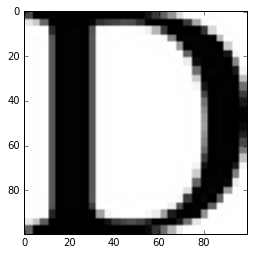

In [24]:
plt.imshow(PIL.Image.fromarray(X[ind].reshape(shape).astype(np.uint8)), cmap='Greys')

In [25]:
class_names[Y[ind]]

'D'

In [26]:
pr = sess.run(final_output, feed_dict={x: [X[ind]]})[0]

In [29]:
sess.run(z, feed_dict={x: [X[ind]]})

array([[ 202.68925476,   61.4432106 ,  311.54827881,  -41.9679451 ,
        -127.5525589 ,  -40.82915497, -114.30521393,  -51.31855392,
         212.30953979,  -15.6612215 ,   39.26654816,  -67.3087616 ,
           4.93250847,  -27.85427094,   45.35705185,  -34.62242889,
         247.20864868, -197.81015015,  -49.12617493,  -96.52230072,
          32.68106842,  149.35926819,  174.72906494,  191.39447021,
          20.96862602, -151.44396973,  -27.14695168,   -7.2129178 ,
        -137.56306458,  167.94235229,   50.02587891,  177.90260315,
          -3.16783953,   33.41209793,   40.18038177,  -44.22656631,
         112.10520172,  -25.64004326, -124.50401306,  178.71977234,
          42.81079865,  -97.27319336,   -6.37768936, -127.00014496,
        -185.48764038,  -88.69172668,  -53.5032692 ,    2.77771831,
          46.17378998,  -64.0843811 ,    9.377635  ,   72.66441345,
          60.03911972,  -56.54162598,  146.84764099,  -30.63629341,
         -31.22215271, -168.82698059,  111.22023

In [27]:
class_names[np.argmax(pr)]

'D'

In [28]:
max(pr)

0.99998724